# Imports and settings

In [ ]:
# Imports and settings.
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from torch.autograd import Variable
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.exceptions import UndefinedMetricWarning
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
!pip install transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertModel
from transformers import get_linear_schedule_with_warmup
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

     |████████████████████████████████| 890kB 4.8MB/s 
     |████████████████████████████████| 3.0MB 22.9MB/s 
     |████████████████████████████████| 890kB 43.6MB/s 
     |████████████████████████████████| 1.1MB 51.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=3078ddb22ed93aa84ae14a55bd31918a71b3241786e6b71e88c1461f8bd584c2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
#Download Tec, CF and Wang datasets and NRC and EmoSenticNet lexicon datasets
!git clone https://gitlab.com/Georgios.Hadjiharalambous/emotion-detection-in-short-texts-datasets
!cp './emotion-detection-in-short-texts-datasets/CrowdFlower.csv' 'CrowdFlower.csv'
!cp './emotion-detection-in-short-texts-datasets/Wang.csv' 'Wang.csv'
!cp './emotion-detection-in-short-texts-datasets/TEC.csv' 'TEC.csv'
!cp './emotion-detection-in-short-texts-datasets/NRC.csv' 'NRC.csv'
!cp './emotion-detection-in-short-texts-datasets/EmoSenticNet.csv' 'EmoSenticNet.csv'

Cloning into 'emotion-detection-in-short-texts-datasets'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.
Cloning into 'new_dat'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 13 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.
Checking out files: 100% (4/4), done.


# Model definition

In [ ]:
#This class is the implementation of Bert lexicon classifier i.e simple Bert with lexicon embeddings and 
#an extra classification layer on top.
#We use the Bert model implementation as provided by the huggingface library
#Link can be fount at https://huggingface.co/transformers/_modules/transformers/modeling_bert.html

class BertClassifierLexicon(nn.Module):
    def __init__(self, model_name, num_labels, lexicon_embedding, lexicon, dropout_prob = 0.5, bert_hidden_size = 768):
      # Initializes the BertClassifierLexicon model object.
      
        # Parameters:
        #     model_name: {String} exact name of the Bert model to be used during training. (Usually "bert-base-uncased")
        #     num_labels: {int} Number of labels.
        #     lexicon_embedding: {torch.Tensor} Pretrained _lexicon_embedding to be loaded.
        #     lexicon: {list} List storing the lexicon dictionary and the reverse vocabulary dictionary.        
        #     dropout_prob : {float} The dropout probability for the classification layer.
        #     bert_hidden_size: {int} Bert hidden dimension for its last-output layer. (Usually for "bert-base-uncased" is 768)        
        

        super().__init__()
        self.num_labels = num_labels
        self.embedding_size = 35 * 4 #max number of words per text * number of emotions used
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_prob)
        self.l1 = nn.Linear(bert_hidden_size + self.embedding_size, num_labels)
        self.lexicon = lexicon
        self.embedding, self.embedding_dimension = self.load_embedding(lexicon_embedding)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

    def load_embedding(self, pretrained_embedding):

        # Loads the pretrained embedding.
        
        # Parameters:
        #     pretrained_embedding: {torch.Tensor} Pretrained embedding to be loaded.

        embedding = torch.nn.Embedding(pretrained_embedding.size(0), pretrained_embedding.size(1))
        embedding.weight = torch.nn.Parameter(pretrained_embedding)
        embedding_dimension = pretrained_embedding.size(1)            
        return embedding, embedding_dimension

      
    def forward(self, input_ids = None, attention_mask = None):
        # Processes the input data to produce the classification output and the attention weight tensor.
        # Parameters:
        #     input_data: {torch.Tensor} Input data.
        #     attention_mask: {torch.Tensor} Indices to avoid performing attention to due to padded tokens

        embedding = self.embedding(input_ids)
        embedding=embedding.view(embedding.size(0), self.embedding_size)

        outputs = self.bert(input_ids, attention_mask = attention_mask)

        pooled_output = torch.cat((outputs[1],embedding),1)
        pooled_output = self.dropout(pooled_output)

        outputs = self.l1(pooled_output)
        outputs = torch.log_softmax(outputs,1) 
        return outputs 

In [ ]:
def load_lexicon():

    # Loads the NRC and EmoSenticNet lexicons and returns a combined lexicon dictionary.

    dataframe = pd.read_csv("EmoSenticNet.csv", delimiter=",", dtype={"word": str, "anger": float, "happiness": float, "sadness": float, 
                                                                      "fear": float})
    lexicon = {row[0]: [row[1], row[2], row[3], row[4]] for row in dataframe.values}
    dataframe = pd.read_csv("NRC.csv", delimiter=",", dtype={"word": str, "emotion": str, "value": float})
    dataframe = dataframe[dataframe.emotion != "anticipation"]
    dataframe = dataframe[dataframe.emotion != "disgust"]
    dataframe = dataframe[dataframe.emotion != "negative"]
    dataframe = dataframe[dataframe.emotion != "positive"]
    dataframe = dataframe[dataframe.emotion != "surprise"]
    dataframe = dataframe[dataframe.emotion != "trust"]
    dataframe_list = dataframe.values.tolist()
    for i in range(0, len(dataframe_list), 4):
        if dataframe_list[i][0] not in lexicon:
            lexicon[dataframe_list[i][0]] = [dataframe_list[i][2], dataframe_list[i + 2][2], dataframe_list[i + 3][2], 
                                             dataframe_list[i + 1][2]]
    return lexicon

# Evaluation Functions


In [ ]:
def get_classes_stats(predicted_output, true_output):

    # Returns the calculated evaluation metrics for each class.
    
    # Parameters:
    #     predicted_output: {numpy.array} Predicted output.
    #     true_output: {numpy.array} True output.

    report_dict = classification_report(true_output, predicted_output, output_dict=True)
    classes = []
    classes_stats = []
    for key in report_dict:
        if key not in ["accuracy", "macro avg", "weighted avg"]:
          classes.append(int(float(key)))
          stats = [float("%0.3f" % (report_dict[key]['precision'])), float("%0.3f" % (report_dict[key]['recall'])), 
                    float("%0.3f" % (report_dict[key]['f1-score'])), report_dict[key]['support']]
          classes_stats.append(stats)
    return [classes, classes_stats]
def create_report(parameters, run_function, num_classes, num_iters):

    # Creates an overall evaluation report after training and testing a model on binary or multiclass classification for a set number of iterations.

    # Parameters:
    #     parameters: {list} List of parameters.
    #     run_function: {function} Function to train and test a model on binary or multiclass classification.
    #     num_classes: {int} Number of classes.
    #     num_iters: {int} Number of iterations.

    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    classes = {}
    print("CREATING REPORT:")
    for i in range(num_iters):
        print("Run: " + str(i + 1))
        result = run_function(parameters[0], parameters[1], parameters[2], parameters[3], False)
        print("Accuracy: %0.3f" % result[0][0])
        print("Precision (WEIGHT_AVG): %0.3f" % result[0][1])
        print("Recall (WEIGHT_AVG): %0.3f" % result[0][2])
        print("F1 (WEIGHT_AVG): %0.3f" % result[0][3])
        accuracy_list.append(result[0][0])
        precision_list.append(result[0][1])
        recall_list.append(result[0][2])
        f1_list.append(result[0][3])
        for j in range(1, num_classes + 1, 1):
            print((str(result[j][0]) + " | Precision: %0.3f Recall: %0.3f F1: %0.3f") % (result[j][1], result[j][2], result[j][3]))
            if result[j][0] not in classes:
                classes[result[j][0]] = {}
            if "Precision_List" not in classes[result[j][0]]:
                classes[result[j][0]]["Precision_List"] = []
            classes[result[j][0]]["Precision_List"].append(result[j][1])
            if "Recall_List" not in classes[result[j][0]]:
                classes[result[j][0]]["Recall_List"] = []
            classes[result[j][0]]["Recall_List"].append(result[j][2])
            if "F1_List" not in classes[result[j][0]]:
                classes[result[j][0]]["F1_List"] = []
            classes[result[j][0]]["F1_List"].append(result[j][3])
    general_stats = [["%0.3f [%0.3f]" % (np.mean(np.asarray(accuracy_list)), np.std(np.asarray(accuracy_list))), 
                      "%0.3f [%0.3f]" % (np.mean(np.asarray(precision_list)), np.std(np.asarray(precision_list))), 
                      "%0.3f [%0.3f]" % (np.mean(np.asarray(recall_list)), np.std(np.asarray(recall_list))), 
                      "%0.3f [%0.3f]" % (np.mean(np.asarray(f1_list)), np.std(np.asarray(f1_list)))]]
    class_labels = []
    class_stats = []
    for key in classes:
        class_labels.append(key)
        precision = "%0.3f [%0.3f]" % (np.mean(np.asarray(classes[key]["Precision_List"])), np.std(np.asarray(classes[key]["Precision_List"])))
        recall = "%0.3f [%0.3f]" % (np.mean(np.asarray(classes[key]["Recall_List"])), np.std(np.asarray(classes[key]["Recall_List"])))
        f1 = "%0.3f [%0.3f]" % (np.mean(np.asarray(classes[key]["F1_List"])), np.std(np.asarray(classes[key]["F1_List"])))
        class_stats.append([precision, recall, f1])
    fig = plt.figure()
    ax = fig.add_subplot(3, 1, 1)  
    col_labels = ["Accuracy [STD]", "Precision (WEIGHT_AVG) [STD]", "Recall (WEIGHT_AVG) [STD]", "F1 (WEIGHT_AVG) [STD]"]
    table = ax.table(cellText=general_stats, rowLabels=[parameters[0]], colLabels=col_labels, loc='center')
    table.scale(3, 3)
    ax.axis('off')
    ax = fig.add_subplot(3, 1, 3)
    col_labels = ["Precision [STD]", "Recall [STD]", "F1 [STD]"]
    table = ax.table(cellText=class_stats, rowLabels=class_labels, colLabels=col_labels, loc='center')
    table.scale(3, 3)
    ax.axis('off')

def plot_confusion_matrix(description, predicted_output, true_output, labels_dict, normalize=False):

    # Plots a confusion matrix for the predicted output.

    # Parameters:
    #     description: {str} Description.
    #     predicted_output: {numpy.array} Predicted output.
    #     true_output: {numpy.array} True output.
    #     labels_dict: {dict} Dictionary of class labels.
    #     normalize: {bool} Normalize values or not.

    title = "Confusion matrix: '%s'" % (description)
    if normalize:
        title = title + " (Normalized)"
    cm = confusion_matrix(true_output, predicted_output)
    classes = get_classes_stats(predicted_output, true_output)[0]
    labels = []
    for item in classes:
        labels.append(labels_dict[item])
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(1, 1, 1)
    cmap = plt.cm.Blues
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), yticklabels=labels)
    ax.set_xticklabels(labels, rotation='vertical')
    ax.set_title(title, fontsize=20)
    ax.set_ylabel("True labels", fontsize=20)
    ax.set_xlabel("Predicted labels", fontsize=20)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    ax.grid(False)

# Dataset Loading and Processing Functions

In [ ]:
def load_vent_multiclass_4():

    # Loads the VENT dataset for multiclass classification with the Bert model.

    labels_dict = {0: "anger", 1: "fear", 2: "sadness", 3: "happiness"}
    dataframe = pd.read_csv("cent4_emot.csv", delimiter=",", dtype={ "emotion": str,  "text": str})
    dataframe.text.astype(str)
    dataframe['text'].replace('', np.nan, inplace=True)
    dataframe.dropna(subset=['text'], inplace=True)
    dataframe = dataframe.drop(dataframe.columns[[0]], axis=1)    
    dataframe["emotion"] = dataframe["emotion"].replace("anger", 0).replace("fear", 1)
    dataframe["emotion"] = dataframe["emotion"].replace("sadness", 2).replace("happiness", 3)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    min_size = 10000
    dataframe_anger = dataframe[dataframe.emotion == 0][:min_size]
    dataframe_fear = dataframe[dataframe.emotion == 1][:min_size]
    dataframe_sadness = dataframe[dataframe.emotion == 2][:min_size]
    dataframe_happiness = dataframe[dataframe.emotion == 3][:min_size]
    dataframe_anger_train = dataframe_anger[:int(0.8 * min_size)]
    dataframe_anger_test = dataframe_anger[int(0.8 * min_size):]
    dataframe_fear_train = dataframe_fear[:int(0.8 * min_size)]
    dataframe_fear_test = dataframe_fear[int(0.8 * min_size):]
    dataframe_sadness_train = dataframe_sadness[:int(0.8 * min_size)]
    dataframe_sadness_test = dataframe_sadness[int(0.8 * min_size):]
    dataframe_happiness_train = dataframe_happiness[:int(0.8 * min_size)]
    dataframe_happiness_test = dataframe_happiness[int(0.8 * min_size):]
    dataframe_train = pd.concat([dataframe_anger_train, dataframe_fear_train, dataframe_sadness_train,
                                 dataframe_happiness_train]).sample(frac=1).reset_index(drop=True)
    dataframe_test = pd.concat([dataframe_anger_test, dataframe_fear_test, dataframe_sadness_test,
                                dataframe_happiness_test]).sample(frac=1).reset_index(drop=True)
    train_list = [dataframe_train["text"], dataframe_train["emotion"]]
    test_list = [dataframe_test["text"], dataframe_test["emotion"]]
    return train_list, test_list, labels_dict



def load_vent_multiclass_5():

    # Loads the VENT dataset (2Pos) for multiclass classification with the Bert model.

    labels_dict = {0: "anger", 1: "fear", 2: "sadness", 3: "happiness",4:'love'}
    dataframe = pd.read_csv("cent5_emot.csv", delimiter=",", dtype={ "emotion": str,  "text": str})
    dataframe.text.astype(str)
    dataframe['text'].replace('', np.nan, inplace=True)
    dataframe.dropna(subset=['text'], inplace=True)
    dataframe = dataframe.drop(dataframe.columns[[0]], axis=1)    
    dataframe["emotion"] = dataframe["emotion"].replace("anger", 0).replace("fear", 1)
    dataframe["emotion"] = dataframe["emotion"].replace("sadness", 2).replace("happiness", 3)
    dataframe["emotion"] = dataframe["emotion"].replace("love", 4)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    min_size = 10000
    dataframe_anger = dataframe[dataframe.emotion == 0][:min_size]
    dataframe_fear = dataframe[dataframe.emotion == 1][:min_size]
    dataframe_sadness = dataframe[dataframe.emotion == 2][:min_size]
    dataframe_happiness = dataframe[dataframe.emotion == 3][:min_size]
    dataframe_love = dataframe[dataframe.emotion == 4][:min_size]
    dataframe_anger_train = dataframe_anger[:int(0.8 * min_size)]
    dataframe_anger_test = dataframe_anger[int(0.8 * min_size):]
    dataframe_fear_train = dataframe_fear[:int(0.8 * min_size)]
    dataframe_fear_test = dataframe_fear[int(0.8 * min_size):]
    dataframe_sadness_train = dataframe_sadness[:int(0.8 * min_size)]
    dataframe_sadness_test = dataframe_sadness[int(0.8 * min_size):]
    dataframe_happiness_train = dataframe_happiness[:int(0.8 * min_size)]
    dataframe_happiness_test = dataframe_happiness[int(0.8 * min_size):]
    dataframe_love_train = dataframe_love[:int(0.8 * min_size)]
    dataframe_love_test = dataframe_love[int(0.8 * min_size):]
    dataframe_train = pd.concat([dataframe_anger_train, dataframe_fear_train, dataframe_sadness_train,
                                 dataframe_happiness_train,dataframe_love_train]).sample(frac=1).reset_index(drop=True)
    dataframe_test = pd.concat([dataframe_anger_test, dataframe_fear_test, dataframe_sadness_test,
                                dataframe_happiness_test,dataframe_love_test]).sample(frac=1).reset_index(drop=True)
    train_list = [dataframe_train["text"], dataframe_train["emotion"]]
    test_list = [dataframe_test["text"], dataframe_test["emotion"]]
    return train_list, test_list, labels_dict



def load_vent_multiclass_6():

    # Loads the VENT dataset (3Pos) for multiclass classification with the Bert model.

    labels_dict = {0: "Anger", 1: "Fear", 2: "Sadness", 3: "Happiness", 4: "Love", 5: "Thankfulness"}
    dataframe = pd.read_csv("cent6_emot.csv", delimiter=",", dtype={ "emotion": str,  "text": str})
    dataframe.text.astype(str)
    dataframe['text'].replace('', np.nan, inplace=True)
    dataframe.dropna(subset=['text'], inplace=True)
    dataframe = dataframe.drop(dataframe.columns[[0]], axis=1)    
    dataframe["emotion"] = dataframe["emotion"].replace("anger", 0).replace("fear", 1)
    dataframe["emotion"] = dataframe["emotion"].replace("sadness", 2).replace("happiness", 3)
    dataframe["emotion"] = dataframe["emotion"].replace("love", 4).replace("thankfulness", 5)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    min_size = 10000
    dataframe_anger = dataframe[dataframe.emotion == 0][:min_size]
    dataframe_fear = dataframe[dataframe.emotion == 1][:min_size]
    dataframe_sadness = dataframe[dataframe.emotion == 2][:min_size]
    dataframe_happiness = dataframe[dataframe.emotion == 3][:min_size]
    dataframe_love = dataframe[dataframe.emotion == 4][:min_size]
    dataframe_thankfulness = dataframe[dataframe.emotion == 5][:min_size]
    dataframe_anger_train = dataframe_anger[:int(0.8 * min_size)]
    dataframe_anger_test = dataframe_anger[int(0.8 * min_size):]
    dataframe_fear_train = dataframe_fear[:int(0.8 * min_size)]
    dataframe_fear_test = dataframe_fear[int(0.8 * min_size):]
    dataframe_sadness_train = dataframe_sadness[:int(0.8 * min_size)]
    dataframe_sadness_test = dataframe_sadness[int(0.8 * min_size):]
    dataframe_happiness_train = dataframe_happiness[:int(0.8 * min_size)]
    dataframe_happiness_test = dataframe_happiness[int(0.8 * min_size):]
    dataframe_love_train = dataframe_love[:int(0.8 * min_size)]
    dataframe_love_test = dataframe_love[int(0.8 * min_size):]
    dataframe_thankfulness_train = dataframe_thankfulness[:int(0.8 * min_size)]
    dataframe_thankfulness_test = dataframe_thankfulness[int(0.8 * min_size):]
    dataframe_train = pd.concat([dataframe_anger_train, dataframe_fear_train, dataframe_sadness_train,
                                 dataframe_happiness_train,dataframe_love_train,dataframe_thankfulness_train]).sample(frac=1).reset_index(drop=True)
    dataframe_test = pd.concat([dataframe_anger_test, dataframe_fear_test, dataframe_sadness_test,dataframe_love_test,
                                dataframe_happiness_test, dataframe_thankfulness_test]).sample(frac=1).reset_index(drop=True)
    train_list = [dataframe_train["text"], dataframe_train["emotion"]]
    test_list = [dataframe_test["text"], dataframe_test["emotion"]]
    return train_list, test_list, labels_dict
    
def load_crowdflower_multiclass():

    # Loads the CrowdFlower dataset for multiclass classification with the Bert model.

    labels_dict = {0: "Anger", 1: "Fear", 2: "Sadness", 3: "Happiness"}
    dataframe = pd.read_csv("CrowdFlower.csv", delimiter=",", dtype={"id": int, "emotion": str, "author": str, "text": str})
    dataframe = dataframe.drop(dataframe.columns[[0, 2]], axis=1)
    dataframe = dataframe[dataframe.emotion != "empty"]
    dataframe = dataframe[dataframe.emotion != "love"]
    dataframe = dataframe[dataframe.emotion != "fun"]
    dataframe = dataframe[dataframe.emotion != "relief"]
    dataframe = dataframe[dataframe.emotion != "enthusiasm"]
    dataframe = dataframe[dataframe.emotion != "boredom"]
    dataframe = dataframe[dataframe.emotion != "anger"]
    dataframe = dataframe[dataframe.emotion != "neutral"]
    dataframe = dataframe[dataframe.emotion != "surprise"]
    dataframe["emotion"] = dataframe["emotion"].replace("hate", 0).replace("worry", 1)
    dataframe["emotion"] = dataframe["emotion"].replace("sadness", 2).replace("happiness", 3)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    min_size = 1310
    dataframe_anger = dataframe[dataframe.emotion == 0][:min_size]
    dataframe_fear = dataframe[dataframe.emotion == 1][:min_size]
    dataframe_sadness = dataframe[dataframe.emotion == 2][:min_size]
    dataframe_happiness = dataframe[dataframe.emotion == 3][:min_size]
    dataframe_anger_train = dataframe_anger[:int(0.8 * min_size)]
    dataframe_anger_test = dataframe_anger[int(0.8 * min_size):]
    dataframe_fear_train = dataframe_fear[:int(0.8 * min_size)]
    dataframe_fear_test = dataframe_fear[int(0.8 * min_size):]
    dataframe_sadness_train = dataframe_sadness[:int(0.8 * min_size)]
    dataframe_sadness_test = dataframe_sadness[int(0.8 * min_size):]
    dataframe_happiness_train = dataframe_happiness[:int(0.8 * min_size)]
    dataframe_happiness_test = dataframe_happiness[int(0.8 * min_size):]
    dataframe_train = pd.concat([dataframe_anger_train, dataframe_fear_train, dataframe_sadness_train,
                                 dataframe_happiness_train]).sample(frac=1).reset_index(drop=True)
    dataframe_test = pd.concat([dataframe_anger_test, dataframe_fear_test, dataframe_sadness_test,
                                dataframe_happiness_test]).sample(frac=1).reset_index(drop=True)
    train_list = [dataframe_train["text"], dataframe_train["emotion"]]
    test_list = [dataframe_test["text"], dataframe_test["emotion"]]
    return train_list, test_list, labels_dict
  
def load_tec_multiclass():

    # Loads the TEC dataset for multiclass classification with the Bert model.

    labels_dict = {0: "Anger", 1: "Fear", 2: "Sadness", 3: "Happiness"}
    dataframe = pd.read_csv("TEC.csv", delimiter=",", dtype={"id": int, "text": str, "emotion": str})
    dataframe = dataframe.drop(dataframe.columns[0], axis=1)
    dataframe = dataframe[dataframe.emotion != "disgust"]
    dataframe = dataframe[dataframe.emotion != "surprise"]
    dataframe["emotion"] = dataframe["emotion"].replace("anger", 0).replace("fear", 1)
    dataframe["emotion"] = dataframe["emotion"].replace("sadness", 2).replace("joy", 3)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    min_size = 1550
    dataframe_anger = dataframe[dataframe.emotion == 0][:min_size]
    dataframe_fear = dataframe[dataframe.emotion == 1][:min_size]
    dataframe_sadness = dataframe[dataframe.emotion == 2][:min_size]
    dataframe_happiness = dataframe[dataframe.emotion == 3][:min_size]
    dataframe_anger_train = dataframe_anger[:int(0.8 * min_size)]
    dataframe_anger_test = dataframe_anger[int(0.8 * min_size):]
    dataframe_fear_train = dataframe_fear[:int(0.8 * min_size)]
    dataframe_fear_test = dataframe_fear[int(0.8 * min_size):]
    dataframe_sadness_train = dataframe_sadness[:int(0.8 * min_size)]
    dataframe_sadness_test = dataframe_sadness[int(0.8 * min_size):]
    dataframe_happiness_train = dataframe_happiness[:int(0.8 * min_size)]
    dataframe_happiness_test = dataframe_happiness[int(0.8 * min_size):]
    dataframe_train = pd.concat([dataframe_anger_train, dataframe_fear_train, dataframe_sadness_train, 
                                 dataframe_happiness_train]).sample(frac=1).reset_index(drop=True)
    dataframe_test = pd.concat([dataframe_anger_test, dataframe_fear_test, dataframe_sadness_test, 
                                dataframe_happiness_test]).sample(frac=1).reset_index(drop=True)
    train_list = [dataframe_train["text"], dataframe_train["emotion"]]
    test_list = [dataframe_test["text"], dataframe_test["emotion"]]
    return train_list, test_list, labels_dict

def load_wang_multiclass():

    # Loads the Wang dataset for multiclass classification with the Bert model.

    labels_dict = {0: "Anger", 1: "Fear", 2: "Sadness", 3: "Happiness"}
    dataframe = pd.read_csv("Wang.csv", delimiter=",", dtype={"id": int, "text": str, "emotion": str})
    dataframe = dataframe.drop(dataframe.columns[0], axis=1)
    dataframe = dataframe[dataframe.emotion != "love"]
    dataframe = dataframe[dataframe.emotion != "thankfulness"]
    dataframe = dataframe[dataframe.emotion != "surprise"]
    dataframe["emotion"] = dataframe["emotion"].replace("anger", 0).replace("fear", 1)
    dataframe["emotion"] = dataframe["emotion"].replace("sadness", 2).replace("joy", 3)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    min_size = 10000
    dataframe_anger = dataframe[dataframe.emotion == 0][:min_size]
    dataframe_fear = dataframe[dataframe.emotion == 1][:min_size]
    dataframe_sadness = dataframe[dataframe.emotion == 2][:min_size]
    dataframe_happiness = dataframe[dataframe.emotion == 3][:min_size]
    dataframe_anger_train = dataframe_anger[:int(0.8 * min_size)]
    dataframe_anger_test = dataframe_anger[int(0.8 * min_size):]
    dataframe_fear_train = dataframe_fear[:int(0.8 * min_size)]
    dataframe_fear_test = dataframe_fear[int(0.8 * min_size):]
    dataframe_sadness_train = dataframe_sadness[:int(0.8 * min_size)]
    dataframe_sadness_test = dataframe_sadness[int(0.8 * min_size):]
    dataframe_happiness_train = dataframe_happiness[:int(0.8 * min_size)]
    dataframe_happiness_test = dataframe_happiness[int(0.8 * min_size):]
    dataframe_train = pd.concat([dataframe_anger_train, dataframe_fear_train, dataframe_sadness_train,
                                 dataframe_happiness_train]).sample(frac=1).reset_index(drop=True)
    dataframe_test = pd.concat([dataframe_anger_test, dataframe_fear_test, dataframe_sadness_test,
                                dataframe_happiness_test]).sample(frac=1).reset_index(drop=True)
    train_list = [dataframe_train["text"], dataframe_train["emotion"]]
    test_list = [dataframe_test["text"], dataframe_test["emotion"]]
    return train_list, test_list, labels_dict

def load_wang_multiclass_6():

    # Loads the Wang dataset for multiclass (3Pos) classification with the Bert model.

    labels_dict = {0: "Anger", 1: "Fear", 2: "Sadness", 3: "Happiness", 4: "Love", 5: "Thankfulness"}
    dataframe = pd.read_csv("Wang.csv", delimiter=",", dtype={"id": int, "text": str, "emotion": str})
    dataframe = dataframe.drop(dataframe.columns[0], axis=1)
    dataframe = dataframe[dataframe.emotion != "surprise"]
    dataframe["emotion"] = dataframe["emotion"].replace("anger", 0).replace("fear", 1)
    dataframe["emotion"] = dataframe["emotion"].replace("sadness", 2).replace("joy", 3)
    dataframe["emotion"] = dataframe["emotion"].replace("love", 4).replace("thankfulness", 5)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    min_size = 10000
    dataframe_anger = dataframe[dataframe.emotion == 0][:min_size]
    dataframe_fear = dataframe[dataframe.emotion == 1][:min_size]
    dataframe_sadness = dataframe[dataframe.emotion == 2][:min_size]
    dataframe_happiness = dataframe[dataframe.emotion == 3][:min_size]
    dataframe_love = dataframe[dataframe.emotion == 4][:min_size]
    dataframe_thankfulness = dataframe[dataframe.emotion == 5][:min_size]
    dataframe_anger_train = dataframe_anger[:int(0.8 * min_size)]
    dataframe_anger_test = dataframe_anger[int(0.8 * min_size):]
    dataframe_fear_train = dataframe_fear[:int(0.8 * min_size)]
    dataframe_fear_test = dataframe_fear[int(0.8 * min_size):]
    dataframe_sadness_train = dataframe_sadness[:int(0.8 * min_size)]
    dataframe_sadness_test = dataframe_sadness[int(0.8 * min_size):]
    dataframe_happiness_train = dataframe_happiness[:int(0.8 * min_size)]
    dataframe_happiness_test = dataframe_happiness[int(0.8 * min_size):]
    dataframe_love_train = dataframe_love[:int(0.8 * min_size)]
    dataframe_love_test = dataframe_love[int(0.8 * min_size):]
    dataframe_thankfulness_train = dataframe_thankfulness[:int(0.8 * min_size)]
    dataframe_thankfulness_test = dataframe_thankfulness[int(0.8 * min_size):]
    dataframe_train = pd.concat([dataframe_anger_train, dataframe_fear_train, dataframe_sadness_train,
                                 dataframe_happiness_train, dataframe_love_train, 
                                 dataframe_thankfulness_train]).sample(frac=1).reset_index(drop=True)
    dataframe_test = pd.concat([dataframe_anger_test, dataframe_fear_test, dataframe_sadness_test,
                                dataframe_happiness_test, dataframe_love_test, 
                                dataframe_thankfulness_test]).sample(frac=1).reset_index(drop=True)
    train_list = [dataframe_train["text"], dataframe_train["emotion"]]
    test_list = [dataframe_test["text"], dataframe_test["emotion"]]
    return train_list, test_list, labels_dict

def load_wang_multiclass_5():

    # Loads the Wang dataset for multiclass (2Pos) classification with the Bert model.

    labels_dict = {0: "Anger", 1: "Fear", 2: "Sadness", 3: "Happiness", 4: "Love"}
    dataframe = pd.read_csv("Wang.csv", delimiter=",", dtype={"id": int, "text": str, "emotion": str})
    dataframe = dataframe.drop(dataframe.columns[0], axis=1)
    dataframe = dataframe[dataframe.emotion != "thankfulness"]
    dataframe = dataframe[dataframe.emotion != "surprise"]
    dataframe["emotion"] = dataframe["emotion"].replace("anger", 0).replace("fear", 1)
    dataframe["emotion"] = dataframe["emotion"].replace("sadness", 2).replace("joy", 3)
    dataframe["emotion"] = dataframe["emotion"].replace("love", 4)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    min_size = 10000
    dataframe_anger = dataframe[dataframe.emotion == 0][:min_size]
    dataframe_fear = dataframe[dataframe.emotion == 1][:min_size]
    dataframe_sadness = dataframe[dataframe.emotion == 2][:min_size]
    dataframe_happiness = dataframe[dataframe.emotion == 3][:min_size]
    dataframe_love = dataframe[dataframe.emotion == 4][:min_size]
    dataframe_anger_train = dataframe_anger[:int(0.8 * min_size)]
    dataframe_anger_test = dataframe_anger[int(0.8 * min_size):]
    dataframe_fear_train = dataframe_fear[:int(0.8 * min_size)]
    dataframe_fear_test = dataframe_fear[int(0.8 * min_size):]
    dataframe_sadness_train = dataframe_sadness[:int(0.8 * min_size)]
    dataframe_sadness_test = dataframe_sadness[int(0.8 * min_size):]
    dataframe_happiness_train = dataframe_happiness[:int(0.8 * min_size)]
    dataframe_happiness_test = dataframe_happiness[int(0.8 * min_size):]
    dataframe_love_train = dataframe_love[:int(0.8 * min_size)]
    dataframe_love_test = dataframe_love[int(0.8 * min_size):]
    dataframe_train = pd.concat([dataframe_anger_train, dataframe_fear_train, dataframe_sadness_train,
                                 dataframe_happiness_train, dataframe_love_train]).sample(frac=1).reset_index(drop=True)
    dataframe_test = pd.concat([dataframe_anger_test, dataframe_fear_test, dataframe_sadness_test,
                                dataframe_happiness_test, dataframe_love_test]).sample(frac=1).reset_index(drop=True)
    train_list = [dataframe_train["text"], dataframe_train["emotion"]]
    test_list = [dataframe_test["text"], dataframe_test["emotion"]]
    return train_list, test_list, labels_dict

In [ ]:
def tokenize_map_pad_mask(sentences,MAX_LEN = 35):
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'                       
                  )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)
    #pad the sentences   
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",
                        value=0, truncating="post", padding="post")
    

  # Create attention masks which provide the indices to avoid performing attention to due to padded tokens
  attention_masks = []
  for sent in input_ids:        
      # Create the attention mask.
      #   - If a token ID is 0, then it's padding, set the mask to 0.
      #   - If a token ID is > 0, then it's a real token, set the mask to 1.
      att_mask = [int(token_id > 0) for token_id in sent]      
      attention_masks.append(att_mask)
  return input_ids, attention_masks, tokenizer.get_vocab()      

# Training and testing functions

In [ ]:
def train(model, train_dataloader, gradient_clipping, scheduler, optimizer, num_epochs=1,verbose=False):
  # Trains the BertClassifier model for multiclass classification 
    # Parameters:
    #     model: {BertClassifier} Bert classifier model to be trained.
    #     train_dataloader: {torch.utils.data.DataLoader} Data loader containing training data.
    #     gradient_clipping: {bool} Use gradient clipping or not.
    #     scheduler : Used for adapting learning rate.
    #     optimizer: {torch.optim.RMSprop} Optimizer to be used in training.
    #     num_epochs: {int} Number of epochs.
    #     verbose: {bool} Verbose or not.

  num_batches=0
  losses=[]
  if torch.cuda.is_available():    
    device = torch.device("cuda")
  else:
    device = torch.device("cpu")
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

  # Store the average loss after each epoch so we can plot them.
  loss_values = []
  accuracies = []
  loss_fct = torch.nn.NLLLoss()
  for epoch_i in range(0, num_epochs):
      
      # Reset the total loss for this epoch.
      total_loss = 0

     
      model.train()

      for step, batch in enumerate(train_dataloader):       

          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using the 
          # `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          input_ids = batch[0].to(device)
          input_mask = batch[1].to(device)
          labels = batch[2].to(device)

          model.zero_grad()        

          # Perform a forward pass (evaluate the model on this training batch).
          
          logits = model(input_ids, attention_mask = input_mask)                   
          loss = loss_fct(logits, labels)          
          total_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()


          if gradient_clipping:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
          
          optimizer.step()

          # Update the learning rate.
          scheduler.step()
          
          num_batches += 1    
      if verbose:
        print("Average loss: %0.3f" % (total_loss / num_batches))      
      losses.append(total_loss / num_batches)
  return losses, accuracies

In [ ]:
def evaluate(model, test_output, prediction_dataloader,verbose=True):
  #Put model in evaluation mode
  model.eval()

  if torch.cuda.is_available():    
    device = torch.device("cuda")
  else:
    device = torch.device("cpu")
  

  # Tracking variables 
  predictions , true_labels = [], []

  # Predict 
  for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    
    input_ids, input_mask, labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        outputs = model(input_ids, attention_mask = input_mask)

    logits = outputs
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

  predictions_=[]
  for pred in predictions:
    predictions_.append(np.argmax(pred,axis=1))
  predicted_test_output=[]
  for batch in predictions_:
    predicted_test_output.extend(batch)
  test_output_var = test_output

  accuracy = accuracy_score(predicted_test_output,test_output_var)
  if verbose:
      print("Accuracy: %0.3f" % (accuracy))
  return accuracy, predicted_test_output

In [ ]:
def evaluation_summary(description, predicted_output, true_output, labels_dict, verbose=True):

    # Returns an evaluation report for the predicted output.

    # Parameters:
    #     description: {str} Description.
    #     predicted_output: {numpy.array} Predicted output.
    #     true_output: {numpy.array} True output.
    #     labels_dict: {dict} Dictionary of class labels.
    #     verbose: {bool} Verbose or not.

    precision = precision_score(true_output, predicted_output, average='weighted')
    recall = recall_score(true_output, predicted_output, average='weighted')
    accuracy = accuracy_score(true_output, predicted_output)
    f1 = fbeta_score(true_output, predicted_output, 1, average='weighted')
    classes = get_classes_stats(predicted_output, true_output)[0]
    classes_stats = get_classes_stats(predicted_output, true_output)[1]
    result = [[accuracy, precision, recall, f1]]
    
    if verbose:
        print("Classifier '%s':" % (description))
        print("Accuracy: %0.3f" % (accuracy))
        print("Precision (WEIGHT_AVG): %0.3f" % (precision))
        print("Recall (WEIGHT_AVG): %0.3f" % (recall))
        print("F1 (WEIGHT_AVG): %0.3f" % (f1))
    for i in range(len(classes)):
        if verbose:
            print((labels_dict[classes[i]] + " | Precision: %0.3f Recall: %0.3f F1: %0.3f Support: " + str(classes_stats[i][3])) % 
                  (classes_stats[i][0], classes_stats[i][1], classes_stats[i][2]))
        result.append([labels_dict[classes[i]], classes_stats[i][0], classes_stats[i][1], classes_stats[i][2]])
    return result

In [ ]:
def load_dataset(load_function, batch_size,max_len, target=None):
    
    # Processes a dataset for the training and testing of the Bert model.

    # Parameters:
    #     load_function: {function} Function to load a dataset.
    #     num_timesteps: {int} Number of LSTM timesteps.
    #     vocabulary_size: {int} Maximal size of the vocabulary.
    #     batch_size: {int} Batch size used in model training.
    #     target: {str} Target class.
    
    if target == None:
        train_set, test_set, labels_dict = load_function()
    else:
        train_set, test_set, labels_dict = load_function(target)
    train_input, train_output = train_set[0], train_set[1]
    test_input, test_output = test_set[0], test_set[1]

    train_input,train_masks,word_to_id = tokenize_map_pad_mask(train_input,max_len)

    train_input = torch.tensor(train_input)
    train_output = torch.tensor(train_output)
    train_masks = torch.tensor(train_masks)

    # Create the DataLoader for our training set.
    train_data = TensorDataset(train_input, train_masks, train_output)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create sentence and label lists
    test_input, test_masks ,_ = tokenize_map_pad_mask(test_input,max_len)

    # Convert to tensors.
    test_input = torch.tensor(test_input)
    test_output = torch.tensor(test_output)  
    test_masks = torch.tensor(test_masks)

    # Create the DataLoader.
    test_data = TensorDataset(test_input, test_masks, test_output)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    return train_dataloader, test_dataloader, test_output, labels_dict ,word_to_id

In [ ]:
def load_embedding_lexicon(word_to_id, lexicon):
 
    # Loads the pretrained embedding from a file and adds the corresponding lexicon embedding.

    # Parameters:
    #     word_to_id: {dict} Vocabulary dictionary.
    #     lexicon: {list} List storing the lexicon dictionary and the reverse vocabulary dictionary.
    
    vocabulary_size = len(word_to_id) + 1
    embedding = np.zeros((vocabulary_size,4))
    for word , index  in word_to_id.items():
      if word in lexicon[0]:
          vector = np.array(lexicon[0][word])
      else:
          vector = np.array([0.0, 0.0, 0.0, 0.0])
      embedding[index] = vector
    return torch.from_numpy(embedding).float()

In [ ]:
def run_multiclass_model(model_name, model_parameters, train_parameters, load_function, verbose=True):

    # Trains and tests the Bert model on multiclass classification.

    # Parameters:
    #     model_name: {str} Name of the model.
    #     model_parameters: {dict} Dictionary of model parameters.
    #     train_parameters: {dict} Dictionary of training parameters.
    #     load_function: {function} Function to load a dataset.
    #     verbose: {bool} Verbose or not.

    train_dataloader, test_dataloader, test_output, labels_dict,word_to_id = load_dataset(load_function, model_parameters["batch_size"],
                                                                               max_len = model_parameters["num_timesteps"])
    
    lexicon_dict = load_lexicon()
    id_to_word = {value: key for key, value in word_to_id.items()}
    lexicon = [lexicon_dict, id_to_word]
    lexicon_embedding = load_embedding_lexicon(word_to_id, lexicon)



    # Load the pretrained BERT model with lexicon embeddings and  a single 
    # linear classification layer on top. 
    model = BertClassifierLexicon(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    model_parameters["num_classes"],  
    lexicon_embedding,
    lexicon, 
    dropout_prob=0.1,
    bert_hidden_size=768
    )
    model.cuda()

    total_steps = len(train_dataloader) * train_parameters["num_epochs"]

    # Create the learning rate scheduler.
    optimizer = AdamW(model.parameters(),
                      lr = 2e-5, 
                      eps = 1e-8 
                    )

    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

    
    if verbose:
        print("MODEL: " + model_name)
    if verbose:
        print("TRAINING:")
    losses, accuracies = train(model,train_dataloader,train_parameters["gradient_clipping"],scheduler,optimizer,train_parameters["num_epochs"],verbose)

  
    if verbose:
        print("POST-TRAINING:")
    post_accuracy, post_predicted_test_output = evaluate(model, test_output,test_dataloader, verbose)
    if verbose:
        print("EVALUATION REPORT:")
    result = evaluation_summary(model_name, post_predicted_test_output, test_output, labels_dict, verbose)
    if verbose:
        plot_confusion_matrix(model_name, post_predicted_test_output, test_output, labels_dict)
        plot_confusion_matrix(model_name, post_predicted_test_output, test_output, labels_dict, True)
    return result

# Multiclass Classification Tests



MODEL: TEC(MULTICLASS)
TRAINING:
Average loss: 1.385
Average loss: 0.635
Average loss: 0.372
Average loss: 0.251
Average loss: 0.191
POST-TRAINING:
Accuracy: 0.600
EVALUATION REPORT:
Classifier 'TEC(MULTICLASS)':
Accuracy: 0.600
Precision (WEIGHT_AVG): 0.605
Recall (WEIGHT_AVG): 0.600
F1 (WEIGHT_AVG): 0.601
Anger | Precision: 0.621 Recall: 0.545 F1: 0.581 Support: 310
Fear | Precision: 0.629 Recall: 0.597 F1: 0.613 Support: 310
Sadness | Precision: 0.524 Recall: 0.632 F1: 0.573 Support: 310
Happiness | Precision: 0.647 Recall: 0.626 F1: 0.636 Support: 310
CREATING REPORT:
Run: 1
Accuracy: 0.594
Precision (WEIGHT_AVG): 0.596
Recall (WEIGHT_AVG): 0.594
F1 (WEIGHT_AVG): 0.593
Anger | Precision: 0.564 Recall: 0.668 F1: 0.612
Fear | Precision: 0.645 Recall: 0.568 F1: 0.604
Sadness | Precision: 0.538 Recall: 0.503 F1: 0.520
Happiness | Precision: 0.635 Recall: 0.635 F1: 0.635
Run: 2
Accuracy: 0.578
Precision (WEIGHT_AVG): 0.573
Recall (WEIGHT_AVG): 0.578
F1 (WEIGHT_AVG): 0.573
Anger | Preci

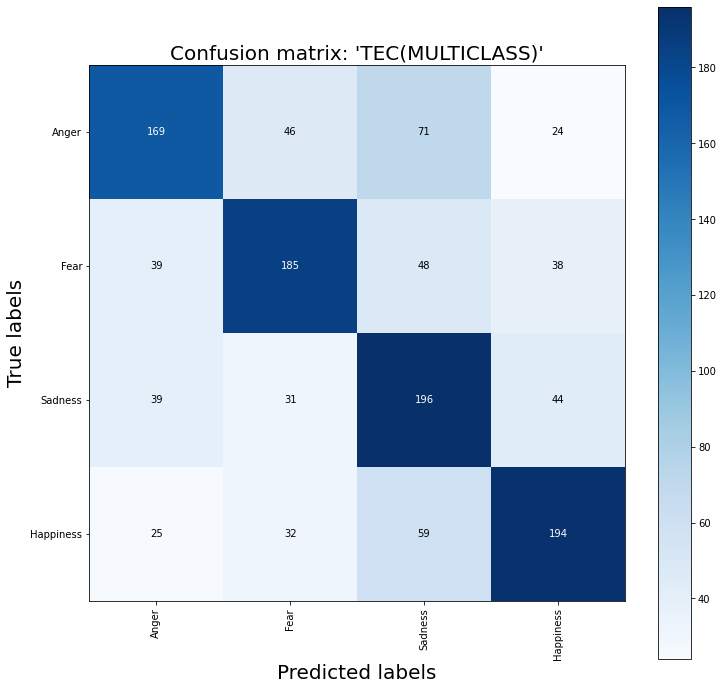

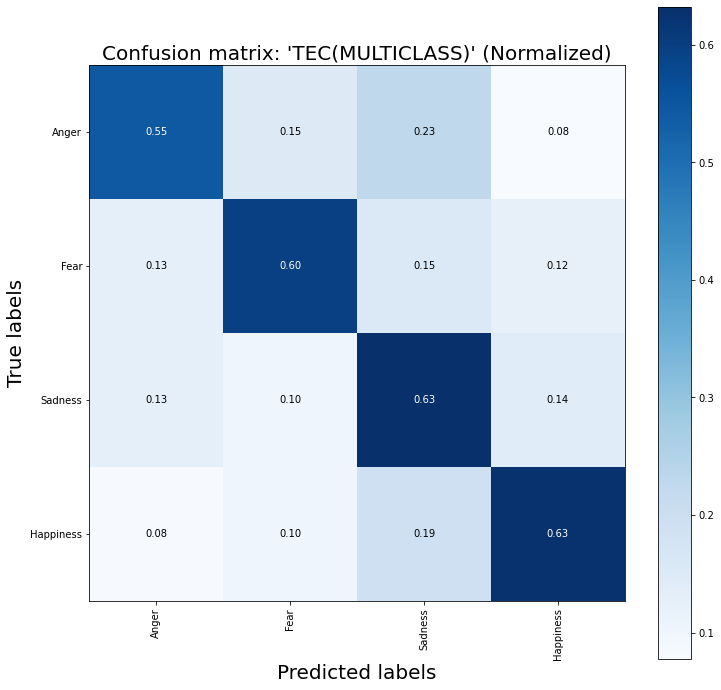

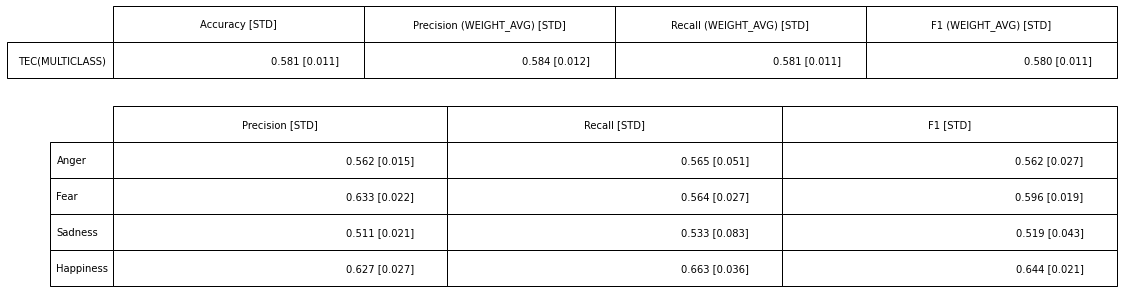

In [ ]:
#evaluate TEC dataset using Bert lexicon classifier model
train_parameters = {
    "num_epochs": 5,
	  "gradient_clipping": True
}

model_parameters = {
    "batch_size": 256,
    "num_timesteps": 35,
    "num_classes": 4
}

result = run_multiclass_model("TEC(MULTICLASS)", model_parameters, train_parameters, load_tec_multiclass)
parameters = ["TEC(MULTICLASS)", model_parameters, train_parameters, load_tec_multiclass]
create_report(parameters, run_multiclass_model, parameters[1]["num_classes"], 10)

MODEL: Crowflower(MULTICLASS)
TRAINING:
Average loss: 1.353
Average loss: 0.536
Average loss: 0.305
Average loss: 0.200
Average loss: 0.143
Average loss: 0.109
POST-TRAINING:
Accuracy: 0.532
EVALUATION REPORT:
Classifier 'Crowflower(MULTICLASS)':
Accuracy: 0.532
Precision (WEIGHT_AVG): 0.529
Recall (WEIGHT_AVG): 0.532
F1 (WEIGHT_AVG): 0.530
Anger | Precision: 0.563 Recall: 0.595 F1: 0.579 Support: 262
Fear | Precision: 0.399 Recall: 0.340 F1: 0.367 Support: 262
Sadness | Precision: 0.440 Recall: 0.477 F1: 0.458 Support: 262
Happiness | Precision: 0.712 Recall: 0.718 F1: 0.715 Support: 262
CREATING REPORT:
Run: 1
Accuracy: 0.551
Precision (WEIGHT_AVG): 0.541
Recall (WEIGHT_AVG): 0.551
F1 (WEIGHT_AVG): 0.544
Anger | Precision: 0.573 Recall: 0.611 F1: 0.591
Fear | Precision: 0.425 Recall: 0.355 F1: 0.387
Sadness | Precision: 0.467 Recall: 0.462 F1: 0.464
Happiness | Precision: 0.698 Recall: 0.775 F1: 0.734
Run: 2
Accuracy: 0.550
Precision (WEIGHT_AVG): 0.546
Recall (WEIGHT_AVG): 0.550
F1 

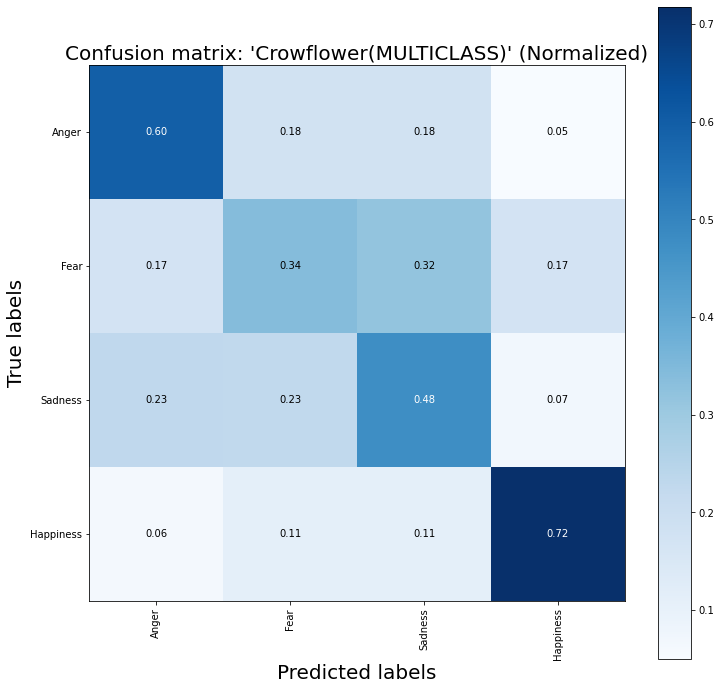

In [ ]:
#Evaluate Crowflower dataset using Bert lexicon classifier model

train_parameters = {
    "num_epochs": 6,
	  "gradient_clipping": True
}

model_parameters = {
    "batch_size": 64,
    "num_timesteps": 35,
    "num_classes": 4
}

result = run_multiclass_model("Crowflower(MULTICLASS)", model_parameters, train_parameters, load_crowdflower_multiclass)
parameters = ["Crowflower(MULTICLASS)", model_parameters, train_parameters, load_crowdflower_multiclass]
create_report(parameters, run_multiclass_model, parameters[1]["num_classes"], 10)

MODEL: Wang
TRAINING:
Average loss: 1.028
Average loss: 0.406
Average loss: 0.232
Average loss: 0.152
Average loss: 0.111
POST-TRAINING:
Accuracy: 0.668
EVALUATION REPORT:
Classifier 'Wang':
Accuracy: 0.668
Precision (WEIGHT_AVG): 0.667
Recall (WEIGHT_AVG): 0.668
F1 (WEIGHT_AVG): 0.668
Anger | Precision: 0.685 Recall: 0.713 F1: 0.699 Support: 2000
Fear | Precision: 0.646 Recall: 0.645 F1: 0.645 Support: 2000
Sadness | Precision: 0.615 Recall: 0.589 F1: 0.602 Support: 2000
Happiness | Precision: 0.725 Recall: 0.726 F1: 0.725 Support: 2000
CREATING REPORT:
Run: 1
Accuracy: 0.663
Precision (WEIGHT_AVG): 0.663
Recall (WEIGHT_AVG): 0.663
F1 (WEIGHT_AVG): 0.663
Anger | Precision: 0.693 Recall: 0.679 F1: 0.686
Fear | Precision: 0.640 Recall: 0.607 F1: 0.623
Sadness | Precision: 0.603 Recall: 0.622 F1: 0.612
Happiness | Precision: 0.716 Recall: 0.745 F1: 0.730
Run: 2
Accuracy: 0.667
Precision (WEIGHT_AVG): 0.667
Recall (WEIGHT_AVG): 0.667
F1 (WEIGHT_AVG): 0.667
Anger | Precision: 0.671 Recall:

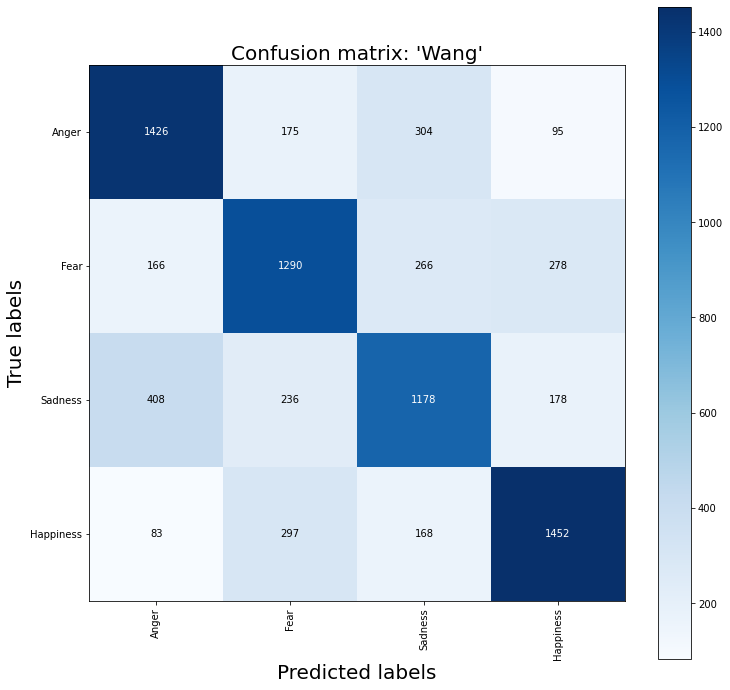

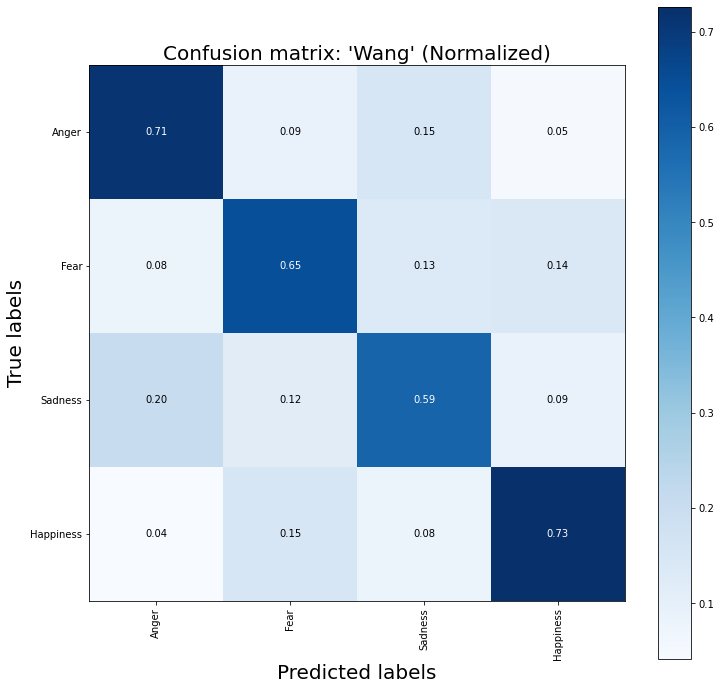

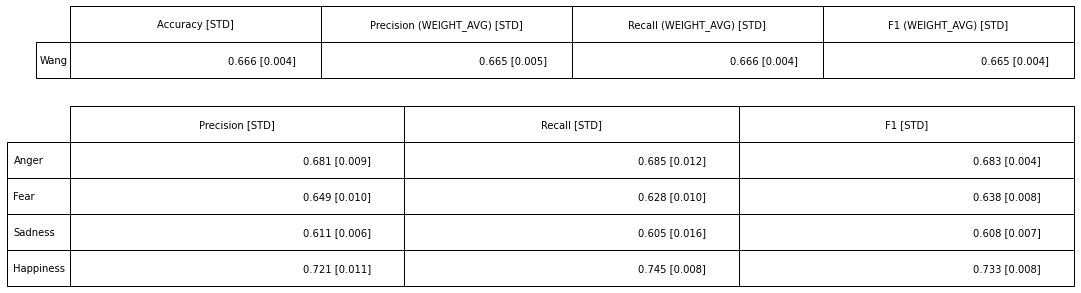

In [ ]:
#Evaluate Wang with 4 emotions dataset using Bert lexicon classifier model

train_parameters = {
    "num_epochs": 5,
	  "gradient_clipping": True
}

model_parameters = {
    "batch_size": 128,
    "num_timesteps": 35,
    "num_classes": 4
}

result = run_multiclass_model("Wang", model_parameters, train_parameters, load_wang_multiclass)
parameters = ["Wang", model_parameters, train_parameters, load_wang_multiclass]
create_report(parameters, run_multiclass_model, parameters[1]["num_classes"], 10)

MODEL: Wang 5
TRAINING:
Average loss: 1.176
Average loss: 0.464
Average loss: 0.255
Average loss: 0.160
Average loss: 0.111
POST-TRAINING:
Accuracy: 0.614
EVALUATION REPORT:
Classifier 'Wang 5':
Accuracy: 0.614
Precision (WEIGHT_AVG): 0.615
Recall (WEIGHT_AVG): 0.614
F1 (WEIGHT_AVG): 0.614
Anger | Precision: 0.665 Recall: 0.630 F1: 0.647 Support: 2000
Fear | Precision: 0.618 Recall: 0.611 F1: 0.614 Support: 2000
Sadness | Precision: 0.556 Recall: 0.595 F1: 0.575 Support: 2000
Happiness | Precision: 0.597 Recall: 0.615 F1: 0.606 Support: 2000
Love | Precision: 0.641 Recall: 0.620 F1: 0.630 Support: 2000
CREATING REPORT:
Run: 1
Accuracy: 0.609
Precision (WEIGHT_AVG): 0.609
Recall (WEIGHT_AVG): 0.609
F1 (WEIGHT_AVG): 0.609
Anger | Precision: 0.657 Recall: 0.668 F1: 0.663
Fear | Precision: 0.613 Recall: 0.601 F1: 0.607
Sadness | Precision: 0.545 Recall: 0.561 F1: 0.553
Happiness | Precision: 0.607 Recall: 0.567 F1: 0.586
Love | Precision: 0.622 Recall: 0.647 F1: 0.635
Run: 2
Accuracy: 0.61

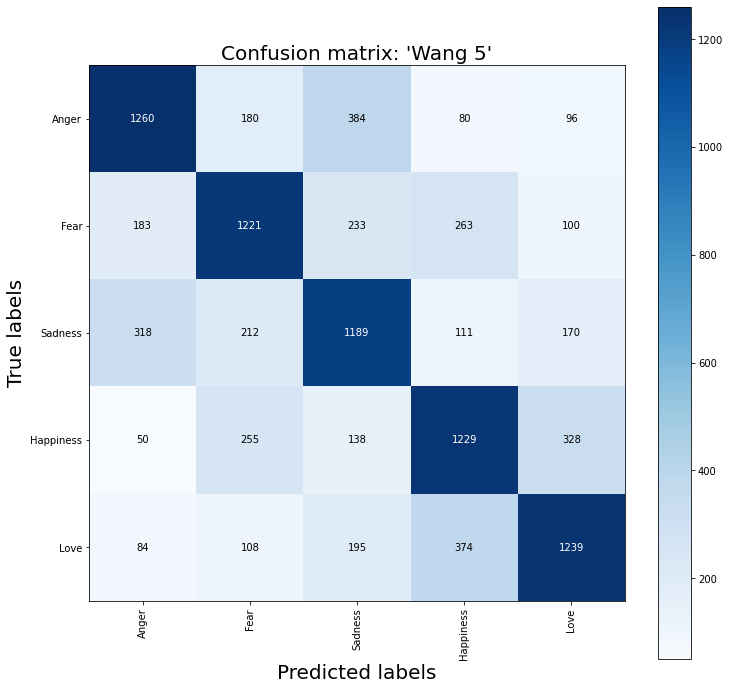

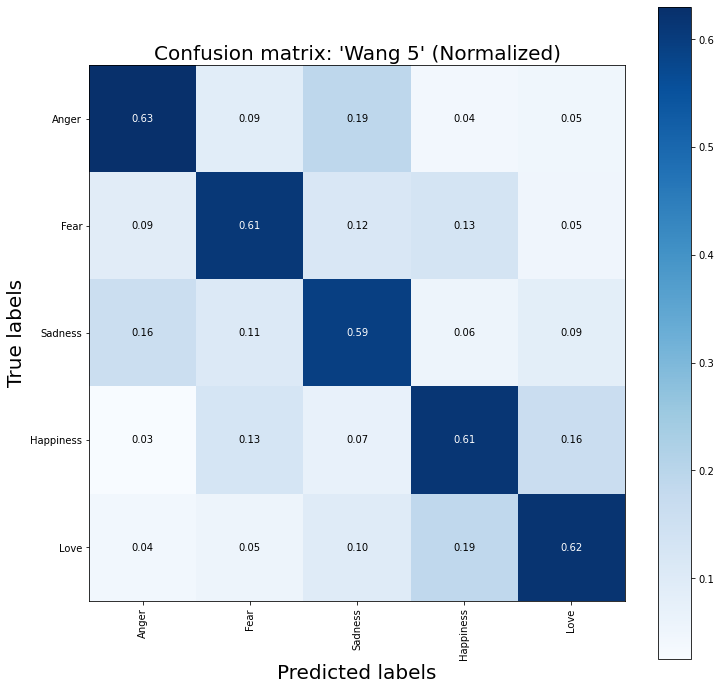

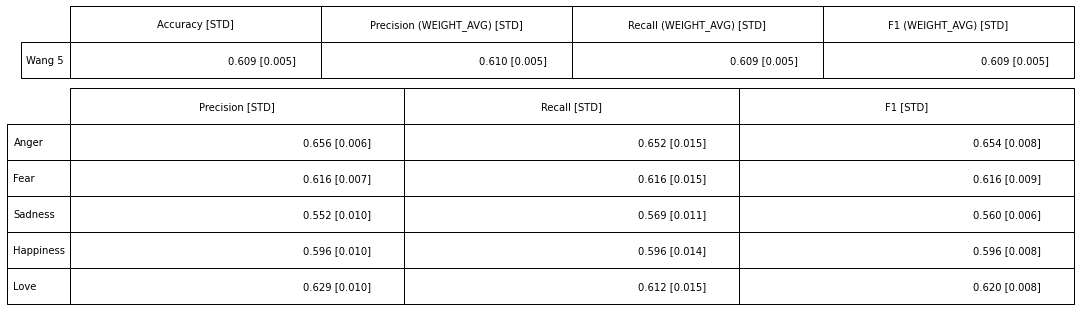

In [ ]:
#Evaluate Wang with 5 emotions dataset using Bert lexicon classifier model

train_parameters = {
    "num_epochs": 5,
	  "gradient_clipping": True
}

model_parameters = {
    "batch_size": 64,
    "num_timesteps": 35,
    "num_classes": 5
}

result = run_multiclass_model("Wang 5", model_parameters, train_parameters, load_wang_multiclass_5)
parameters = ["Wang 5 ", model_parameters, train_parameters, load_wang_multiclass_5]
create_report(parameters, run_multiclass_model, parameters[1]["num_classes"], 10)


MODEL: Wang 6
TRAINING:
Average loss: 1.265
Average loss: 0.499
Average loss: 0.276
Average loss: 0.175
Average loss: 0.122
POST-TRAINING:
Accuracy: 0.592
EVALUATION REPORT:
Classifier 'Wang 6':
Accuracy: 0.592
Precision (WEIGHT_AVG): 0.592
Recall (WEIGHT_AVG): 0.592
F1 (WEIGHT_AVG): 0.592
Anger | Precision: 0.630 Recall: 0.647 F1: 0.638 Support: 2000
Fear | Precision: 0.614 Recall: 0.577 F1: 0.594 Support: 2000
Sadness | Precision: 0.528 Recall: 0.560 F1: 0.544 Support: 2000
Happiness | Precision: 0.541 Recall: 0.554 F1: 0.548 Support: 2000
Love | Precision: 0.557 Recall: 0.502 F1: 0.528 Support: 2000
Thankfulness | Precision: 0.683 Recall: 0.713 F1: 0.697 Support: 2000
CREATING REPORT:
Run: 1
Accuracy: 0.600
Precision (WEIGHT_AVG): 0.599
Recall (WEIGHT_AVG): 0.600
F1 (WEIGHT_AVG): 0.599
Anger | Precision: 0.638 Recall: 0.652 F1: 0.645
Fear | Precision: 0.593 Recall: 0.583 F1: 0.588
Sadness | Precision: 0.549 Recall: 0.532 F1: 0.540
Happiness | Precision: 0.558 Recall: 0.556 F1: 0.55

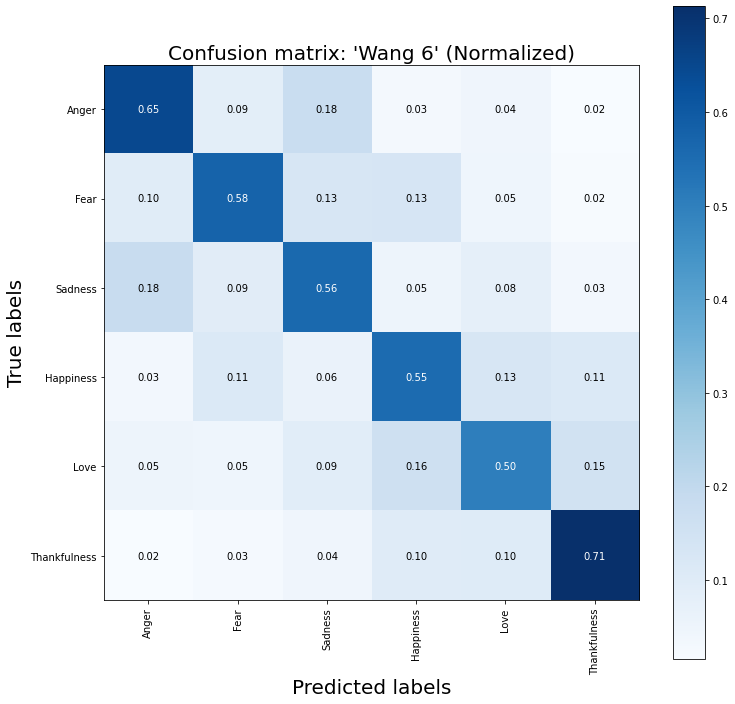

In [ ]:
#Evaluate Wang with 6 emotions dataset using Bert lexicon classifier model

train_parameters = {
    "num_epochs": 5,
	  "gradient_clipping": True
}

model_parameters = {
    "batch_size": 64,
    "num_timesteps": 35,
    "num_classes": 6
}

result = run_multiclass_model("Wang 6", model_parameters, train_parameters, load_wang_multiclass_6)
parameters = ["Wang 6 ", model_parameters, train_parameters, load_wang_multiclass_6]
create_report(parameters, run_multiclass_model, parameters[1]["num_classes"], 10)


MODEL: vent4
TRAINING:
Average loss: 0.994
Average loss: 0.395
Average loss: 0.233
Average loss: 0.157
Average loss: 0.116
POST-TRAINING:
Accuracy: 0.654
EVALUATION REPORT:
Classifier 'vent4':
Accuracy: 0.654
Precision (WEIGHT_AVG): 0.657
Recall (WEIGHT_AVG): 0.654
F1 (WEIGHT_AVG): 0.655
anger | Precision: 0.610 Recall: 0.660 F1: 0.634 Support: 2000
fear | Precision: 0.653 Recall: 0.586 F1: 0.618 Support: 2000
sadness | Precision: 0.567 Recall: 0.597 F1: 0.582 Support: 2000
happiness | Precision: 0.798 Recall: 0.772 F1: 0.785 Support: 2000
CREATING REPORT:
Run: 1
Accuracy: 0.665
Precision (WEIGHT_AVG): 0.667
Recall (WEIGHT_AVG): 0.665
F1 (WEIGHT_AVG): 0.666
anger | Precision: 0.623 Recall: 0.675 F1: 0.648
fear | Precision: 0.643 Recall: 0.587 F1: 0.613
sadness | Precision: 0.591 Recall: 0.612 F1: 0.601
happiness | Precision: 0.813 Recall: 0.787 F1: 0.800
Run: 2


Token indices sequence length is longer than the specified maximum sequence length for this model (1581 > 512). Running this sequence through the model will result in indexing errors


Accuracy: 0.668
Precision (WEIGHT_AVG): 0.671
Recall (WEIGHT_AVG): 0.668
F1 (WEIGHT_AVG): 0.668
anger | Precision: 0.629 Recall: 0.666 F1: 0.647
fear | Precision: 0.661 Recall: 0.575 F1: 0.615
sadness | Precision: 0.592 Recall: 0.644 F1: 0.617
happiness | Precision: 0.801 Recall: 0.788 F1: 0.794
Run: 3
Accuracy: 0.672
Precision (WEIGHT_AVG): 0.674
Recall (WEIGHT_AVG): 0.672
F1 (WEIGHT_AVG): 0.673
anger | Precision: 0.649 Recall: 0.670 F1: 0.660
fear | Precision: 0.640 Recall: 0.605 F1: 0.622
sadness | Precision: 0.584 Recall: 0.619 F1: 0.601
happiness | Precision: 0.824 Recall: 0.792 F1: 0.808
Run: 4
Accuracy: 0.670
Precision (WEIGHT_AVG): 0.672
Recall (WEIGHT_AVG): 0.670
F1 (WEIGHT_AVG): 0.670
anger | Precision: 0.631 Recall: 0.680 F1: 0.655
fear | Precision: 0.659 Recall: 0.609 F1: 0.633
sadness | Precision: 0.591 Recall: 0.606 F1: 0.598
happiness | Precision: 0.806 Recall: 0.784 F1: 0.795
Run: 5


Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors


Accuracy: 0.669
Precision (WEIGHT_AVG): 0.671
Recall (WEIGHT_AVG): 0.669
F1 (WEIGHT_AVG): 0.670
anger | Precision: 0.635 Recall: 0.664 F1: 0.649
fear | Precision: 0.651 Recall: 0.597 F1: 0.622
sadness | Precision: 0.600 Recall: 0.628 F1: 0.614
happiness | Precision: 0.797 Recall: 0.788 F1: 0.793


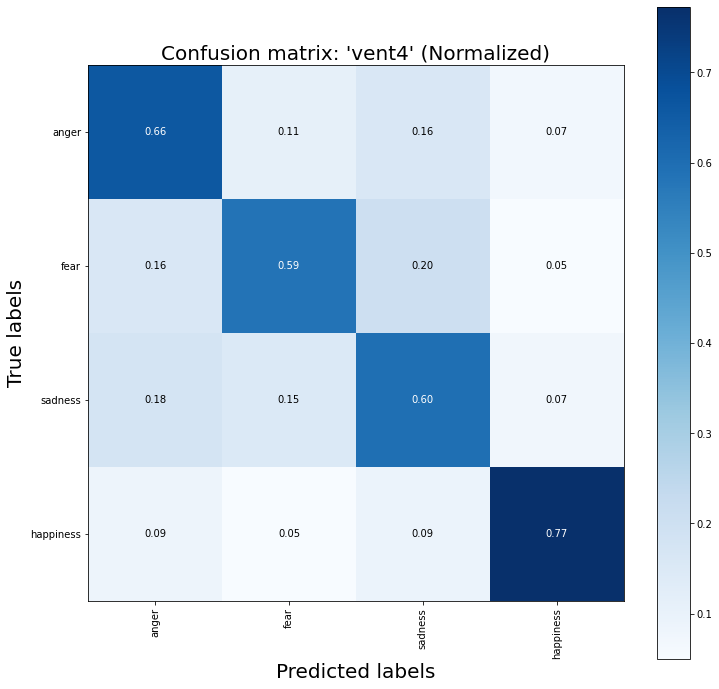

In [ ]:
#Evaluate Vent dataset with 4 emotions using Bert classifier model
 
train_parameters = {
    "num_epochs": 5,
	  "gradient_clipping": True
}

model_parameters = {
    "batch_size": 128,
    "num_timesteps": 35,
    "num_classes": 4
}
#The dataset is required to run this cell, which is not provided publicly due to authors restrictions

result = run_multiclass_model("Vent 4", model_parameters, train_parameters, load_vent_multiclass_4)
parameters = ["Vent 4", model_parameters, train_parameters, load_vent_multiclass_4]
create_report(parameters, run_multiclass_model, parameters[1]["num_classes"], 10)

MODEL: Vent 5
TRAINING:
Average loss: 1.182
Average loss: 0.476
Average loss: 0.280
Average loss: 0.190
Average loss: 0.141
POST-TRAINING:
Accuracy: 0.622
EVALUATION REPORT:
Classifier 'Vent 5':
Accuracy: 0.622
Precision (WEIGHT_AVG): 0.624
Recall (WEIGHT_AVG): 0.622
F1 (WEIGHT_AVG): 0.622
anger | Precision: 0.632 Recall: 0.635 F1: 0.634 Support: 2000
fear | Precision: 0.632 Recall: 0.605 F1: 0.618 Support: 2000
sadness | Precision: 0.544 Recall: 0.612 F1: 0.576 Support: 2000
happiness | Precision: 0.667 Recall: 0.682 F1: 0.674 Support: 2000
love | Precision: 0.646 Recall: 0.575 F1: 0.609 Support: 2000
CREATING REPORT:
Run: 1
Accuracy: 0.618
Precision (WEIGHT_AVG): 0.620
Recall (WEIGHT_AVG): 0.618
F1 (WEIGHT_AVG): 0.617
anger | Precision: 0.620 Recall: 0.650 F1: 0.635
fear | Precision: 0.624 Recall: 0.584 F1: 0.603
sadness | Precision: 0.543 Recall: 0.598 F1: 0.569
happiness | Precision: 0.651 Recall: 0.711 F1: 0.680
love | Precision: 0.663 Recall: 0.546 F1: 0.599
Run: 2
Accuracy: 0.60

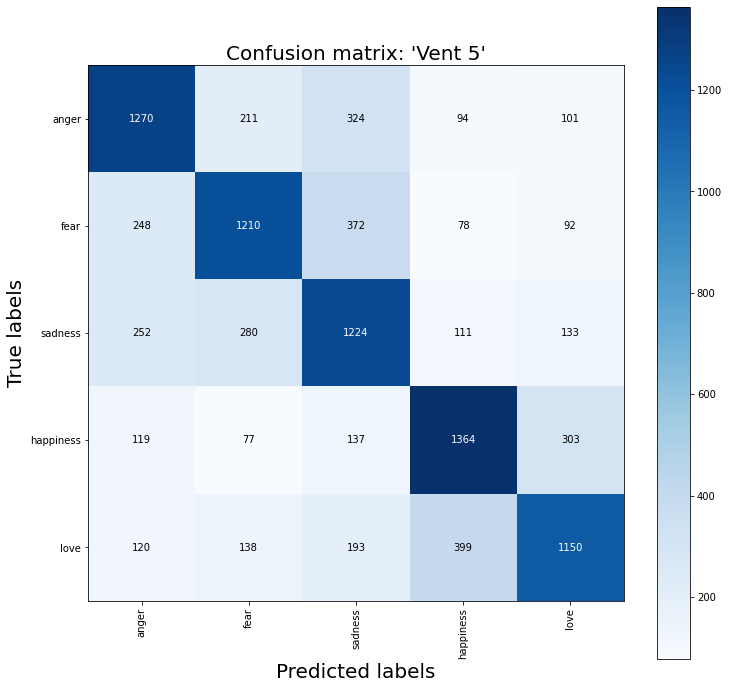

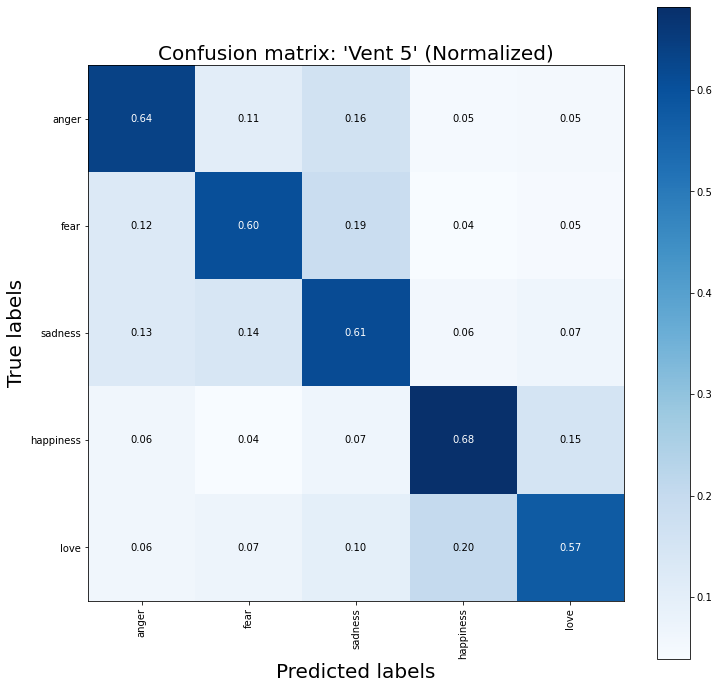

In [ ]:
#Evaluate Vent dataset with 5 emotions using Bert classifier model
train_parameters = {
    "num_epochs": 5,
	  "gradient_clipping": True
}

model_parameters = {
    "batch_size": 128,
    "num_timesteps": 35,
    "num_classes": 5
}
#The dataset is required to run this cell, which is not provided publicly due to authors restrictions

result = run_multiclass_model("Vent 5", model_parameters, train_parameters, load_vent_multiclass_5)
parameters = ["Vent 5", model_parameters, train_parameters, load_vent_multiclass_5]
create_report(parameters, run_multiclass_model, parameters[1]["num_classes"], 10)

MODEL: vent6
TRAINING:
Average loss: 1.352
Average loss: 0.553
Average loss: 0.339
Average loss: 0.239
Average loss: 0.184
POST-TRAINING:
Accuracy: 0.562
EVALUATION REPORT:
Classifier 'vent6':
Accuracy: 0.562
Precision (WEIGHT_AVG): 0.566
Recall (WEIGHT_AVG): 0.562
F1 (WEIGHT_AVG): 0.563
Anger | Precision: 0.583 Recall: 0.628 F1: 0.605 Support: 2000
Fear | Precision: 0.619 Recall: 0.548 F1: 0.581 Support: 2000
Sadness | Precision: 0.525 Recall: 0.589 F1: 0.555 Support: 2000
Happiness | Precision: 0.521 Recall: 0.540 F1: 0.531 Support: 2000
Love | Precision: 0.531 Recall: 0.542 F1: 0.536 Support: 2000
Thankfulness | Precision: 0.615 Recall: 0.526 F1: 0.568 Support: 2000
CREATING REPORT:
Run: 1


Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors


Accuracy: 0.571
Precision (WEIGHT_AVG): 0.574
Recall (WEIGHT_AVG): 0.571
F1 (WEIGHT_AVG): 0.571
Anger | Precision: 0.593 Recall: 0.649 F1: 0.620
Fear | Precision: 0.615 Recall: 0.543 F1: 0.577
Sadness | Precision: 0.534 Recall: 0.583 F1: 0.557
Happiness | Precision: 0.536 Recall: 0.547 F1: 0.542
Love | Precision: 0.543 Recall: 0.572 F1: 0.557
Thankfulness | Precision: 0.622 Recall: 0.533 F1: 0.574
Run: 2


Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors


Accuracy: 0.570
Precision (WEIGHT_AVG): 0.574
Recall (WEIGHT_AVG): 0.570
F1 (WEIGHT_AVG): 0.570
Anger | Precision: 0.588 Recall: 0.620 F1: 0.604
Fear | Precision: 0.615 Recall: 0.555 F1: 0.584
Sadness | Precision: 0.529 Recall: 0.591 F1: 0.558
Happiness | Precision: 0.525 Recall: 0.563 F1: 0.544
Love | Precision: 0.534 Recall: 0.529 F1: 0.532
Thankfulness | Precision: 0.649 Recall: 0.561 F1: 0.602
Run: 3


Token indices sequence length is longer than the specified maximum sequence length for this model (954 > 512). Running this sequence through the model will result in indexing errors


Accuracy: 0.567
Precision (WEIGHT_AVG): 0.570
Recall (WEIGHT_AVG): 0.567
F1 (WEIGHT_AVG): 0.568
Anger | Precision: 0.597 Recall: 0.624 F1: 0.610
Fear | Precision: 0.594 Recall: 0.553 F1: 0.573
Sadness | Precision: 0.524 Recall: 0.572 F1: 0.547
Happiness | Precision: 0.538 Recall: 0.563 F1: 0.550
Love | Precision: 0.537 Recall: 0.544 F1: 0.541
Thankfulness | Precision: 0.629 Recall: 0.549 F1: 0.586
Run: 4


Token indices sequence length is longer than the specified maximum sequence length for this model (1446 > 512). Running this sequence through the model will result in indexing errors


Accuracy: 0.571
Precision (WEIGHT_AVG): 0.574
Recall (WEIGHT_AVG): 0.571
F1 (WEIGHT_AVG): 0.571
Anger | Precision: 0.607 Recall: 0.632 F1: 0.619
Fear | Precision: 0.610 Recall: 0.555 F1: 0.581
Sadness | Precision: 0.526 Recall: 0.583 F1: 0.553
Happiness | Precision: 0.534 Recall: 0.550 F1: 0.542
Love | Precision: 0.527 Recall: 0.557 F1: 0.542
Thankfulness | Precision: 0.641 Recall: 0.547 F1: 0.590
Run: 5
Accuracy: 0.578
Precision (WEIGHT_AVG): 0.580
Recall (WEIGHT_AVG): 0.578
F1 (WEIGHT_AVG): 0.578
Anger | Precision: 0.615 Recall: 0.631 F1: 0.623
Fear | Precision: 0.624 Recall: 0.585 F1: 0.604
Sadness | Precision: 0.527 Recall: 0.582 F1: 0.553
Happiness | Precision: 0.546 Recall: 0.564 F1: 0.554
Love | Precision: 0.544 Recall: 0.551 F1: 0.548
Thankfulness | Precision: 0.626 Recall: 0.555 F1: 0.588


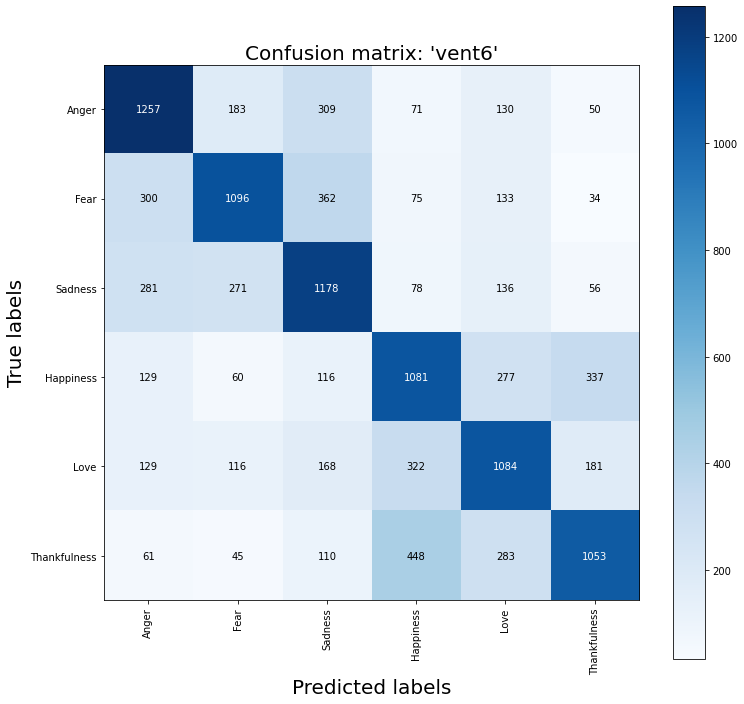

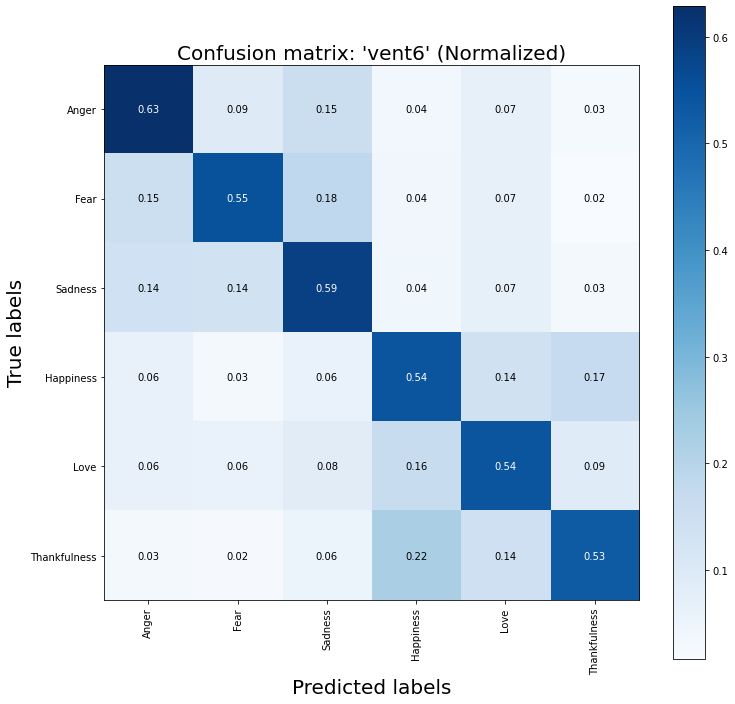

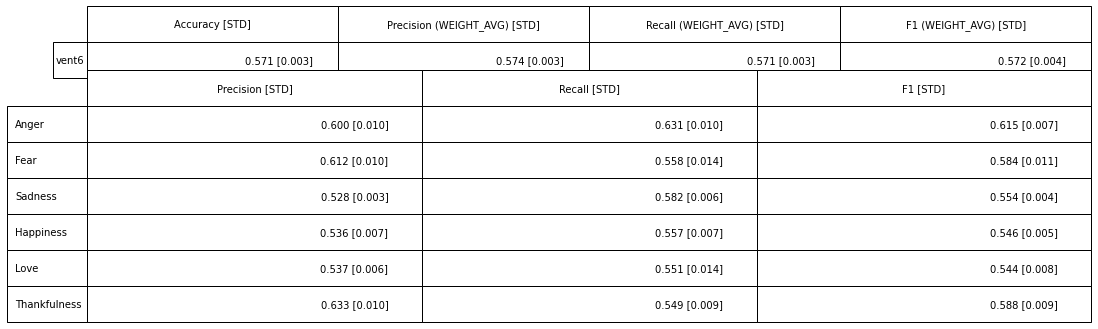

In [ ]:
#Evaluate Vent dataset with  emotions using Bert classifier model
train_parameters = {
    "num_epochs": 5,
	  "gradient_clipping": True
}

model_parameters = {
    "batch_size": 256,
    "num_timesteps": 35,
    "num_classes": 6
}
#The dataset is required to run this cell, which is not provided publicly due to authors restrictions

result = run_multiclass_model("Vent 6", model_parameters, train_parameters, load_vent_multiclass_6)
parameters = ["Vent 6", model_parameters, train_parameters, load_vent_multiclass_6]
create_report(parameters, run_multiclass_model, parameters[1]["num_classes"], 10)